# Input-Output Generation

In [1]:
! pip install control

In [1]:
import control as ctrl
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class DataGenerator:

	def __init__(
		self,
		n_config,			# select TF configuration
		sampling_rate=100, 	# sampling of the signals
		time_length=9,		# length of the simulation (no leading 0)
		initial_zero=1,		# length is seconds of initial 0
		fixed_period_n=True,
	):
		# store values
		self.sampling_freq = 1/sampling_rate
		self.time_length = time_length
		self.initial_zero = initial_zero
		self.fixed_period_n = fixed_period_n,

		# select configuration
		s = ctrl.tf('s')
		if n_config == 0:
			self.G = 2**2 / (s**2 + 2*0.3*2*s + 2**2)
		elif n_config == 1:
			self.G = 2**2 / (s**2 + 2*0.3*2*s + 2**2) + 7**2 / (s**2 + 2*0.6*7*s + 7**2)
		elif n_config == 2:
			self.G = (s**2 - 3*s - 4) / (s**2 + 5*s + 6)
		else:
			raise Exception("Invalid configuration number")

		print(f"TF: {self.G}")


	def sine_wave_response(self, freq, silent=True):
		return self.response(0, freq, float('NaN'), silent)


	def impulse_response(self, ampl=10, silent=True):
		return self.response(1, float('NaN'), ampl, silent)


	def response(self, type, freq, ampl, silent=True):
		t_zero = np.arange(0, self.initial_zero, self.sampling_freq)
		t_sim = np.arange(self.initial_zero, self.initial_zero+self.time_length, self.sampling_freq)

		if type == 0 and self.fixed_period_n:
			time_period = 1/freq
			periods_n = self.time_length / time_period
			remaining_period_fraction = periods_n - math.floor(periods_n)
			if remaining_period_fraction != 1e-4:
				missing_part = (1 - remaining_period_fraction) * time_period
				t_addition = np.arange(self.initial_zero+self.time_length, self.initial_zero+self.time_length+missing_part, self.sampling_freq)
				t_sim = np.hstack((t_sim, t_addition))

		t = np.hstack((t_zero, t_sim))

		leading_zero = np.zeros(len(t_zero), dtype=float)
		if type == 0:
			input_signal = np.sin(2 * np.pi * freq * (t_sim - self.initial_zero))
		elif type == 1:
			input_signal = np.zeros_like(t_sim)
			input_signal[0] = ampl
		else:
			raise Exception("Invalid response type")
		u = np.hstack((leading_zero, input_signal))

		t_resp, y = ctrl.forced_response(self.G, T=t, U=u)

		if not silent:
			plt.figure()
			plt.plot(t, y, label="output")
			if type != 1:
				plt.plot(t, u, label="input", linestyle="--")
			plt.legend()
		
		return {'time': t, 'input': u, 'response': y}

TF: <TransferFunction>: sys[9]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4



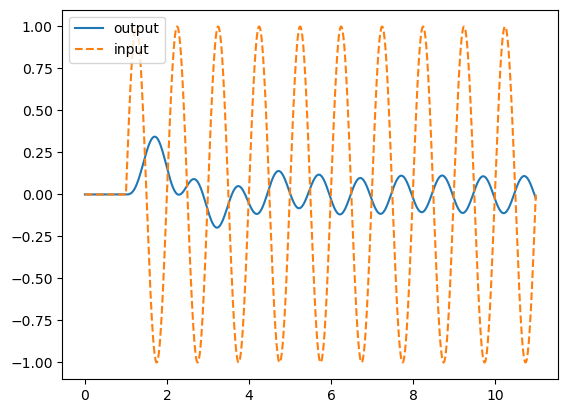

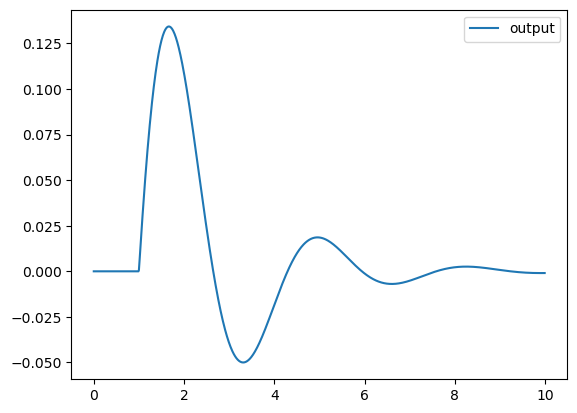

In [3]:
dg = DataGenerator(0)
_ = dg.sine_wave_response(1.001, silent=False)
_ = dg.impulse_response(silent=False)

# Multi-step LSTM

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

import os
from IPython.display import clear_output
from tqdm import tqdm

## Network Definitions

### Dataset

In [5]:
class FeedbackTimeSeriesDataset(Dataset):
    
    def __init__(self, input_data, output_data, seq_len, feedback_len, pred_steps):
        self.input_data = torch.FloatTensor(input_data)
        self.output_data = torch.FloatTensor(output_data)
        self.seq_len = seq_len
        self.feedback_len = feedback_len
        self.pred_steps = pred_steps
        
    def __len__(self):
        return len(self.input_data) - self.seq_len - self.pred_steps + 1
    
    def __getitem__(self, idx):
        # get input and corresponding output sequence
        X = self.input_data[idx : idx+self.seq_len]
        fb = self.output_data[idx : idx+self.feedback_len]
        y = self.output_data[idx+self.seq_len : idx+self.seq_len+self.pred_steps]
        return X, fb, y

### Network

In [6]:
class PositionalEncoding(nn.Module):
	def __init__(self, d_model, dropout=0.1, max_len=5000):
		super().__init__()

		self.dropout = nn.Dropout(p=dropout)
		position = torch.arange(max_len).unsqueeze(1)
		div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
		
		pe = torch.zeros(max_len, 1, d_model)
		pe[:, 0, 0::2] = torch.sin(position * div_term)
		pe[:, 0, 1::2] = torch.cos(position * div_term)

		self.register_buffer('pe', pe)

	def forward(self, x):
		x = x + self.pe[:x.size(0)]
		return self.dropout(x)


class EncoderDynamicalSystemModel(nn.Module):
    
	def __init__(self,
			     input_len,
				 feedback_len,
				 device,
				 compress_seq_len=64,
				 embed_size=16,
				 num_layers=2,
				 n_head=4,
				 dim_feedforward=2048,
				 dropout=0.1,
				 conv1d_emb=True,
				 conv1d_kernel_size=3,
			):
		super(EncoderDynamicalSystemModel, self).__init__()

		self.input_len = input_len
		self.feedback_len = feedback_len
		self.device = device
		self.compress_seq_len = compress_seq_len
		self.embed_size = embed_size
		self.num_layers = num_layers
		self.n_head = n_head
		self.conv1d_emb = conv1d_emb
		self.conv1d_kernel_size = conv1d_kernel_size

		if conv1d_emb:
			if conv1d_kernel_size % 2 == 0:
				raise Exception("Kernel size must be odd to preserve dimensions")
			self.conv1d_padding = self.conv1d_kernel_size - 1
			self.input_embedding = nn.Conv1d(1, embed_size, kernel_size=conv1d_kernel_size)
			self.feedback_embedding = nn.Conv1d(1, embed_size, kernel_size=conv1d_kernel_size)
		else:
			self.input_embedding = nn.Linear(1, embed_size)
			self.feedback_embedding = nn.Linear(1, embed_size)

		self.compression = nn.Sequential(
			nn.Linear(input_len+feedback_len, 2 * compress_seq_len),
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(2 * compress_seq_len, compress_seq_len),
			nn.LayerNorm(compress_seq_len),
		)

		self.position_encoder = PositionalEncoding(
			d_model=embed_size,
			dropout=dropout,
			max_len=compress_seq_len,
		)
		
		encoder_layer = nn.TransformerEncoderLayer(
			d_model=embed_size,
			nhead=n_head,
			dim_feedforward=dim_feedforward,
			dropout=dropout,
			batch_first=True
        )
		self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

		self.regression = nn.Sequential(
			nn.Linear(compress_seq_len*embed_size, dim_feedforward),
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(dim_feedforward, dim_feedforward // 2),
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(dim_feedforward // 2, dim_feedforward // 4),
			nn.ReLU(),
			nn.Linear(dim_feedforward // 4, 1),
		)

		self.global_skip = nn.Linear(input_len+feedback_len, 1)

		self._init_weights()

	def _init_weights(self):
		for p in self.parameters():
			if p.dim() > 1:
				nn.init.xavier_uniform_(p)

	def forward(self, u, fb):
		src_mask = self._generate_square_subsequent_mask()

		global_skip = self.global_skip(torch.cat((u, fb), dim=1).squeeze(-1))
		
		if self.conv1d_emb:
			u = nn.functional.pad(u, (0, 0, self.conv1d_padding, 0), "constant", -1)
			u = self.input_embedding(u.transpose(1, 2))
			u = u.transpose(1, 2)
		else:
			u = self.input_embedding(u)

		if self.conv1d_emb:
			fb = nn.functional.pad(fb, (0, 0, self.conv1d_padding, 0), "constant", -1)
			fb = self.feedback_embedding(fb.transpose(1, 2))
			fb = fb.transpose(1, 2)
		else:
			fb = self.feedback_embedding(fb)

		x = torch.cat((u, fb), dim=1)

		x = x.transpose(1, 2)
		x = self.compression(x)
		x = x.transpose(1, 2)

		x = self.position_encoder(x)
		x = self.transformer_encoder(x, mask=src_mask)
		x = x.reshape((-1, (self.compress_seq_len) * self.embed_size))

		return self.regression(x) + global_skip

	def _generate_square_subsequent_mask(self):
		return torch.triu(
			torch.full(
				(self.compress_seq_len, self.compress_seq_len),
				float('-inf'), dtype=torch.float32, device=self.device
			),
			diagonal=1
		).to(self.device)
	
	def str_id(self):
		return f"encoder_{self.compress_seq_len}_{self.embed_size}_{self.num_layers}_{self.n_head}_{self.conv1d_emb}_{self.conv1d_kernel_size}"

### Training

In [7]:
def plot_losses(train_losses, val_losses, title='Training Progress'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.yscale('log')  # Log scale often better for loss visualization
    
    # Add min loss annotations
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    plt.annotate(f'Min Train Loss: {min_train_loss:.4f}', 
                xy=(train_losses.index(min_train_loss), min_train_loss),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'Min Val Loss: {min_val_loss:.4f}', 
                xy=(val_losses.index(min_val_loss), min_val_loss),
                xytext=(10, -10), textcoords='offset points')
    
    plt.tight_layout()
    
def plot_training_progress(train_losses, val_losses, epoch, num_epochs, clear=True):
    if clear:
        clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Progress (Epoch {epoch+1}/{num_epochs})')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.yscale('log')
    
    # Add current loss values
    if train_losses and val_losses:
        plt.annotate(f'Train Loss: {train_losses[-1]:.4f}', 
                    xy=(len(train_losses)-1, train_losses[-1]),
                    xytext=(10, 10), textcoords='offset points')
        plt.annotate(f'Val Loss: {val_losses[-1]:.4f}', 
                    xy=(len(val_losses)-1, val_losses[-1]),
                    xytext=(10, -10), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stop_patience=5, folder="pytorch_models"):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    with open(os.path.join(folder, f'{model.str_id()}_training_log.txt'), 'w') as f:
        f.write('Epoch,Train Loss,Val Loss\n')
    
    for epoch in tqdm(range(num_epochs), desc='Training Epochs'):
        # training phase
        model.train()
        tot_train_loss = 0
        batch_size = len(train_loader)
        
        for batch_idx, (in_data, fb_data, out_data) in enumerate(train_loader):
            in_data, fb_data, out_data = in_data.to(device), fb_data.to(device), out_data.to(device)
            
            # forward pass
            optimizer.zero_grad()
            model_output = model(in_data, fb_data)
            loss = criterion(model_output.unsqueeze(1), out_data)
            
            # backward pass
            loss.backward()
            optimizer.step()
            
            tot_train_loss += loss.item()
            
        avg_train_loss = tot_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # validation phase
        model.eval()
        tot_val_loss = 0
        with torch.no_grad():
            for in_data, fb_data, out_data in val_loader:
                in_data, fb_data, out_data = in_data.to(device), fb_data.to(device), out_data.to(device)
                model_output = model(in_data, fb_data)
                loss = criterion(model_output.unsqueeze(1), out_data)
                tot_val_loss += loss.item()

                
        avg_val_loss = tot_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        plot_training_progress(train_losses, val_losses, epoch, num_epochs)
        with open(os.path.join(folder, f'{model.str_id()}_training_log.txt'), 'a') as f:
            f.write(f'{epoch+1}/{num_epochs}, {avg_train_loss:.9f}, {avg_val_loss:.9f}\n')
        
        # early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            os.makedirs(folder, exist_ok=True)
            torch.save(model.state_dict(), f"{folder}/{model.str_id()}.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("\nEarly stopping triggered")
                break
            
    plot_losses(train_losses, val_losses, title='Final Training Results')
    return train_losses, val_losses     

In [9]:
def fft_magnitude(signal):
	return torch.abs(torch.fft.fft(signal))

class LossCriterion(nn.Module):
    
	def __init__(self, weight=0.5):
		super().__init__()
		self.weight = weight

	def forward(self, pred, targ):
		mse_time = torch.mean((pred - targ) ** 2)
		mse_fft = torch.mean((fft_magnitude(pred) - fft_magnitude(targ)) ** 2)
		return mse_time + self.weight * mse_fft


## Training

### Parameters

In [10]:
# Parameters
min_f = 1	# 0.1
max_f = 10	# 10
step_f = 0.05	# 0.01
train_freq = np.arange(min_f, max_f+step_f, step_f)
val_freq = np.arange(min_f+step_f/2, max_f+step_f, step_f*4)
test_freq = np.arange(min_f+3*step_f/2, max_f+step_f, step_f*4)

lookback_len = 200    	# Lookback window
feedback_len = 100    	# Feedback window
predict_len = 1  		# Lookahead steps
sampling_rate = 100 	# Sampling rate
time_length = 10   		# Length of simulation (s)
initial_zero = 2   		# Length of initial zero (s)
total_samples = (time_length + initial_zero) * sampling_rate

batch_size_train = 4
batch_size_val = 8
batch_size_test = 4

compress_seq_len=64
embed_size=4
num_layers=2
n_head=4
dim_feedforward=64
dropout=0.1
conv1d_emb=True
conv1d_kernel_size=3

num_epochs = 100
learning_rate = 5e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_folder = "LSTM_team"

def print_f_set(name, array):
    print(f"{name}\n  Length: {len(array)}, [{array[0]}, {array[1]}, {array[2]}, ..., {array[-3]}, {array[-2]}, {array[-1]}]")
print_f_set("Train Set", train_freq)
print_f_set("Validation Set", val_freq)
print_f_set("Test Set", test_freq)

Train Set
  Length: 181, [1.0, 1.05, 1.1, ..., 9.900000000000007, 9.950000000000008, 10.000000000000007]
Validation Set
  Length: 46, [1.025, 1.2249999999999999, 1.4249999999999998, ..., 9.624999999999998, 9.824999999999998, 10.024999999999999]
Test Set
  Length: 45, [1.075, 1.275, 1.4749999999999999, ..., 9.474999999999998, 9.674999999999997, 9.874999999999996]


In [11]:
print(device)
torch.cuda.device_count()

cuda


4

### Data Generation

In [12]:
# generate data for training, validation, and testing
data_generator = DataGenerator(0, sampling_rate, time_length, initial_zero)

train_data = [data_generator.sine_wave_response(freq) for freq in train_freq]
val_data = [data_generator.sine_wave_response(freq) for freq in val_freq]
test_data = [data_generator.sine_wave_response(freq) for freq in test_freq]

# extract input and output data
scaler = StandardScaler()
def extract_data(data, label):
	out = np.array([]).reshape(-1,1)
	for d in data:
		d = np.array(d[label]).reshape(-1,1)
		#d = scaler.fit_transform(d)
		out = np.concatenate((out, d))
	return out

train_input, train_output = extract_data(train_data, 'input'), extract_data(train_data, 'response')
val_input, val_output = extract_data(val_data, 'input'), extract_data(val_data, 'response')
test_input, test_output = extract_data(test_data, 'input'), extract_data(test_data, 'response')

# normalize data
input_scaler = StandardScaler()
output_scaler = StandardScaler()
train_input = input_scaler.fit_transform(train_input)
train_output = output_scaler.fit_transform(train_output)
val_input = input_scaler.transform(val_input)
val_output = output_scaler.transform(val_output)
test_input = input_scaler.transform(test_input)
test_output = output_scaler.transform(test_output)

# create datasets
train_dataset = FeedbackTimeSeriesDataset(train_input, train_output, lookback_len, feedback_len, predict_len)
val_dataset = FeedbackTimeSeriesDataset(val_input, val_output, lookback_len, feedback_len, predict_len)
test_dataset = FeedbackTimeSeriesDataset(test_input, test_output, lookback_len, feedback_len, predict_len)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size_val, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size_test, shuffle=False)

TF: <TransferFunction>: sys[21]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4



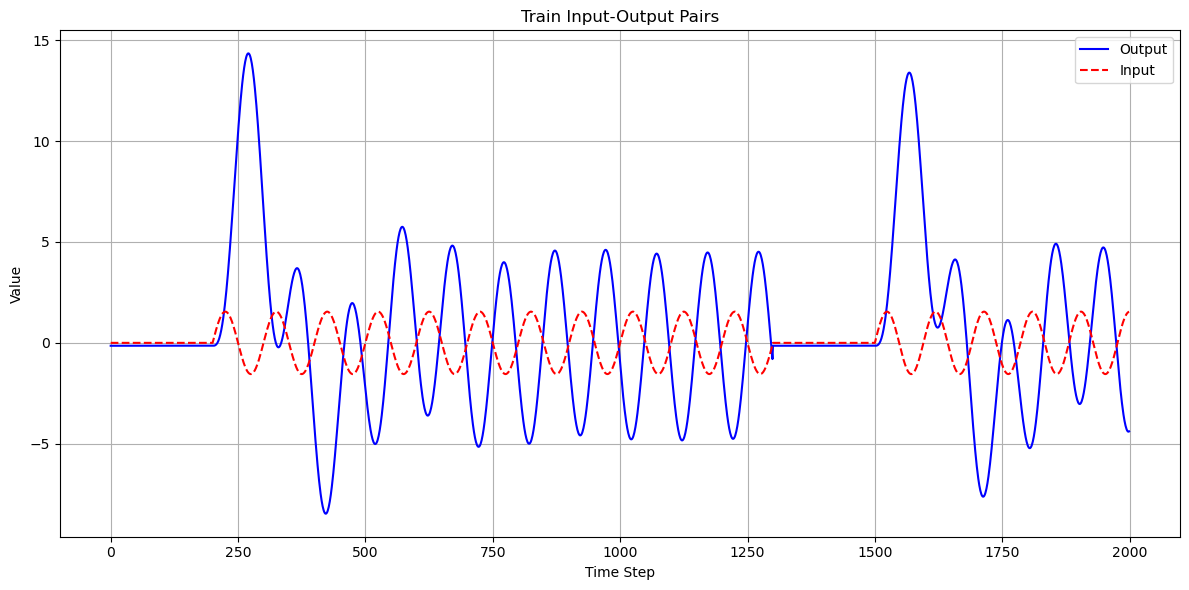

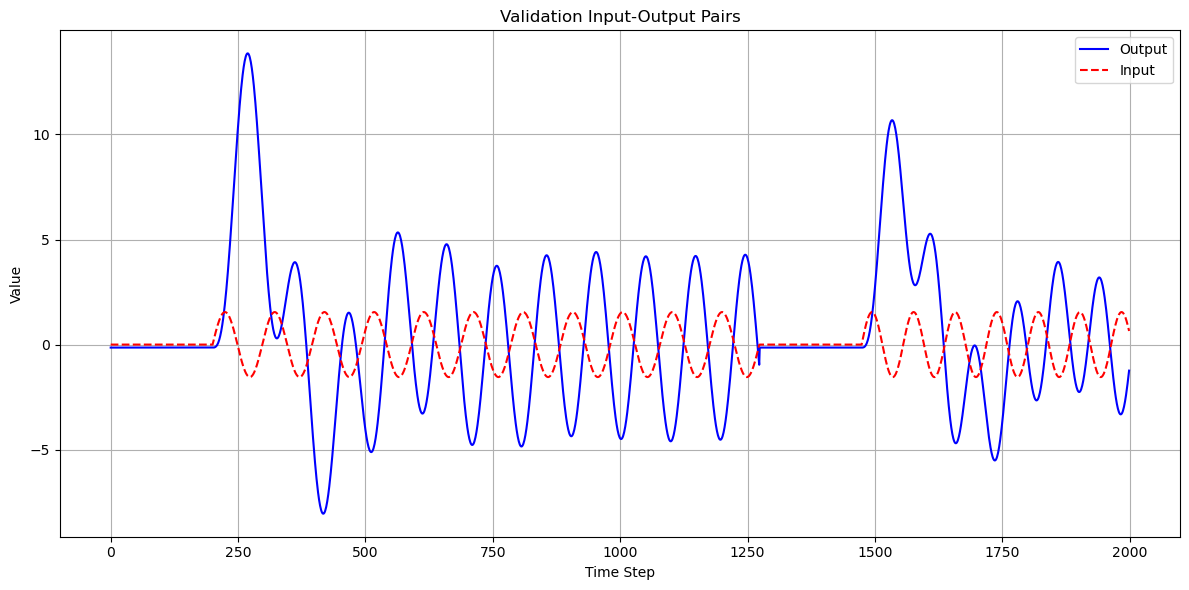

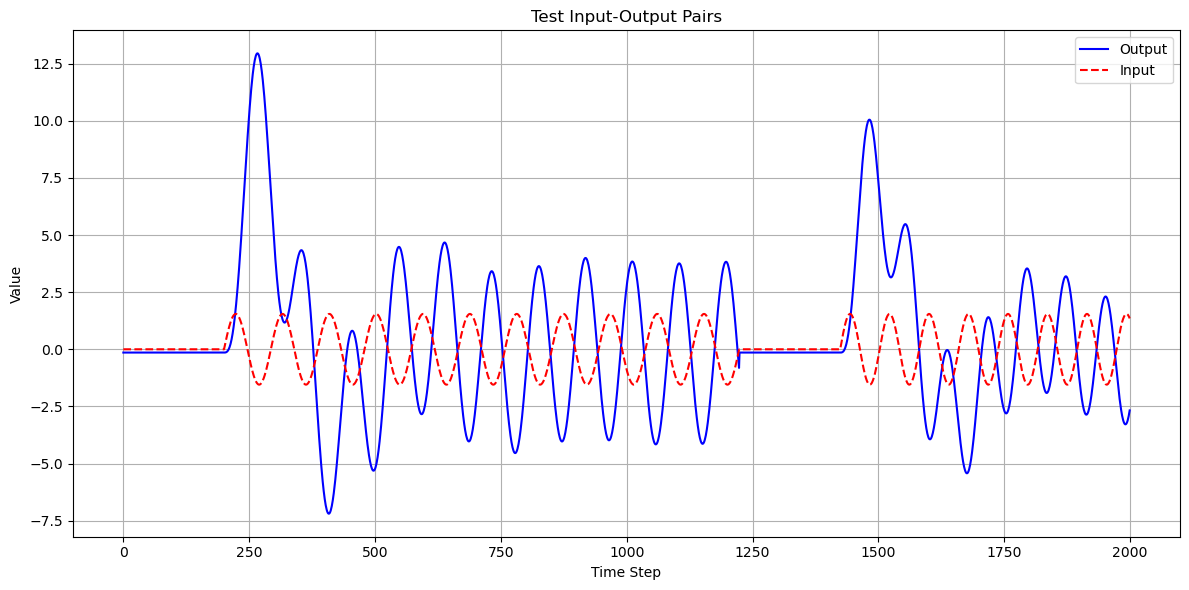

In [13]:
def plot_input_output_pairs(input_data, output_data, title, start=0, end=2000):
	plt.figure(figsize=(12, 6))
	plt.plot(output_data[start:end], label='Output', color='blue')
	plt.plot(input_data[start:end], label='Input', color='red', linestyle='--')
	plt.title(f'{title} Input-Output Pairs')
	plt.xlabel('Time Step')
	plt.ylabel('Value')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

# Example usage:
plot_input_output_pairs(train_input, train_output, 'Train')
plot_input_output_pairs(val_input, val_output, 'Validation')
plot_input_output_pairs(test_input, test_output, 'Test')

### Train

In [17]:
model = EncoderDynamicalSystemModel(
    input_len=lookback_len,
    feedback_len=feedback_len,
    device=device,
    compress_seq_len=compress_seq_len,
    embed_size=embed_size,
    num_layers=num_layers,
    n_head=n_head,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    conv1d_emb=conv1d_emb,
    conv1d_kernel_size=conv1d_kernel_size,
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
print(model)
print(f"\nNumber of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

EncoderDynamicalSystemModel(
  (input_embedding): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (feedback_embedding): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (compression): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=4, bias=True)
        (norm1): LayerNorm(

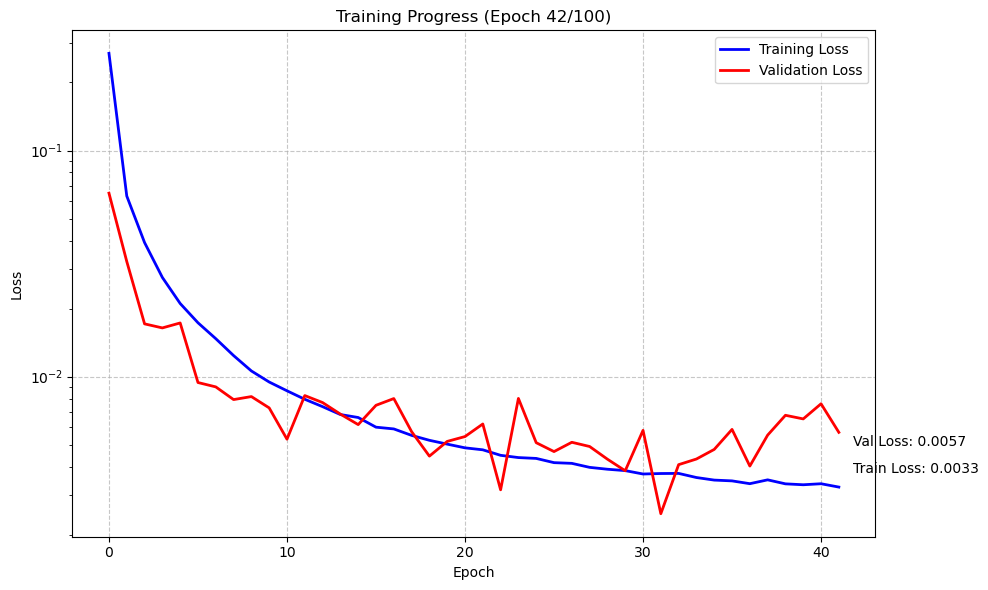

Training Epochs:  41%|████      | 41/100 [8:22:21<12:02:55, 735.17s/it]


Early stopping triggered


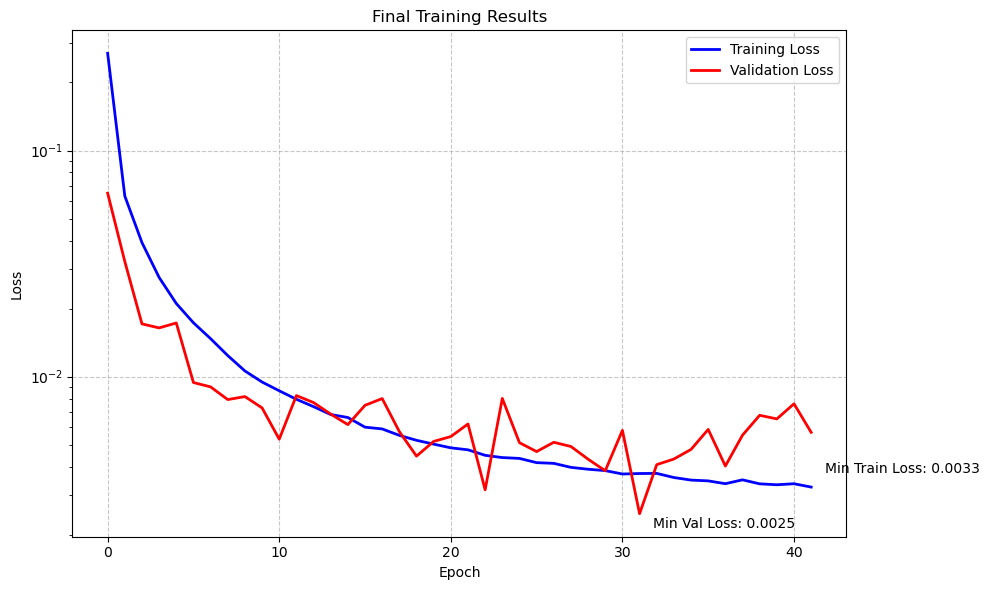

In [74]:
train_losses, val_losses = train_model(
    model.to(device),
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    early_stop_patience=10,
    folder=f"{base_folder}/pytorch_models"
)

### Plot for Training

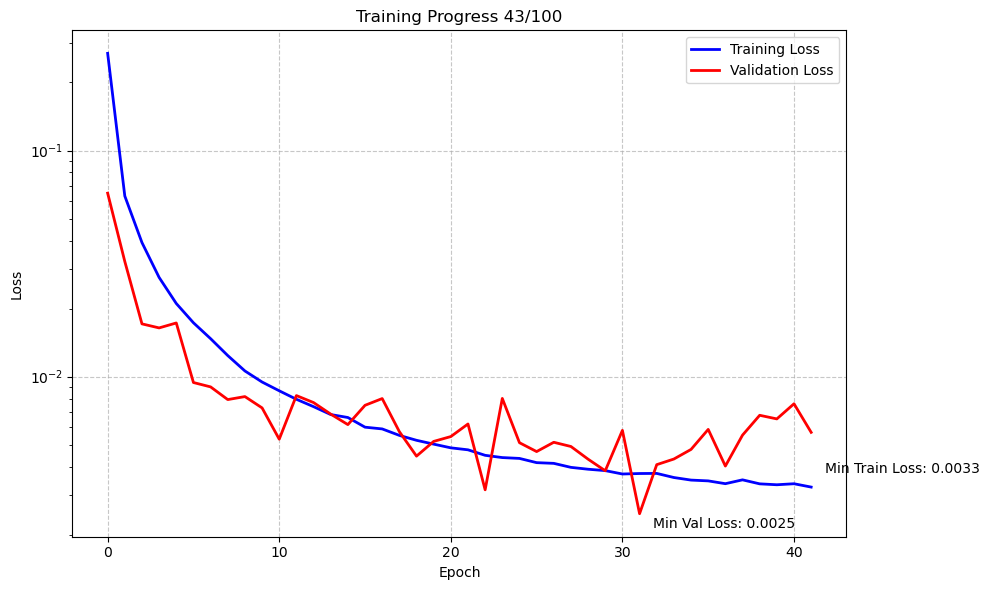

In [14]:
model = EncoderDynamicalSystemModel(
	input_len=lookback_len,
	feedback_len=feedback_len,
	device=device,
	compress_seq_len=compress_seq_len,
	embed_size=embed_size,
	num_layers=num_layers,
	n_head=n_head,
	dim_feedforward=dim_feedforward,
	dropout=dropout,
	conv1d_emb=conv1d_emb,
	conv1d_kernel_size=conv1d_kernel_size,
)
folder = f"{base_folder}/pytorch_models"
log_file = os.path.join(folder, f'{model.str_id()}_training_log.txt')

train_losses = []
val_losses = []

with open(log_file, 'r') as f:
	for line in f:
		if line[0].isdigit():
			parts = line.strip().split(',')
			epoch = int(parts[0].split('/')[0])
			num_epochs = int(parts[0].split('/')[1])
			train_loss = float(parts[1].strip())
			val_loss = float(parts[2].strip())
			train_losses.append(train_loss)
			val_losses.append(val_loss)

plot_losses(train_losses, val_losses, title=f'Training Progress {epoch+1}/{num_epochs}')

## Testing

In [19]:
model = EncoderDynamicalSystemModel(
	input_len=lookback_len,
	feedback_len=feedback_len,
	device=device,
	compress_seq_len=compress_seq_len,
	embed_size=embed_size,
	num_layers=num_layers,
	n_head=n_head,
	dim_feedforward=dim_feedforward,
	dropout=dropout,
	conv1d_emb=conv1d_emb,
	conv1d_kernel_size=conv1d_kernel_size,
)
folder = f"{base_folder}/pytorch_models"
model.load_state_dict(torch.load(f'{folder}/{model.str_id()}.pth', weights_only=True))
model.to(device)
print(model)

EncoderDynamicalSystemModel(
  (input_embedding): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (feedback_embedding): Conv1d(1, 4, kernel_size=(3,), stride=(1,))
  (compression): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=4, bias=True)
        (norm1): LayerNorm(

### Test Set Loss

In [20]:
# test the model
model.eval()
test_losses = []
with torch.no_grad():
    for in_data, fb_data, out_data in tqdm(test_loader):
        in_data, fb_data, out_data = in_data.to(device), fb_data.to(device), out_data.to(device)
        model_output = model(in_data, fb_data)
        loss = criterion(model_output.unsqueeze(1), out_data)
        test_losses.append(loss.item())
        
print(f'Test Loss: {np.mean(test_losses):.4f}')

100%|██████████| 13528/13528 [00:45<00:00, 296.79it/s]

Test Loss: 0.0020


### Visualize Predictions

In [21]:
def generate_predictions(model, input_data, output_data, lookback_len, feedback_len, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        # We can only start predicting after we have enough history
        for i in tqdm(range(len(input_data) - lookback_len), desc='Generating Predictions'):
            # Get input sequence
            input_seq = input_data[i:i + lookback_len]
            output_seq = output_data[i:i + feedback_len]

            # Prepare input tensor
            input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)
            output_tensor = torch.FloatTensor(output_seq).unsqueeze(0).to(device)

            # Make prediction
            pred = model(input_tensor, output_tensor)
            predictions.append(pred.cpu().numpy()[0][0])

            # Get corresponding actual value
            actuals.append(output_data[i + lookback_len][0])

    return np.array(predictions), np.array(actuals)

def plot_predictions(predictions, actuals, title="Model Predictions vs Actual Values", samples=range(1,1000)):
    plt.figure(figsize=(12, 6))

    # Plot only the specified number of samples for clarity
    x = np.arange(len(predictions))[samples]
    plt.plot(x, actuals[samples], label='Actual', color='blue')
    plt.plot(x, predictions[samples], label='Predicted', color='red', linestyle='--')

    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_metrics(predictions, actuals):
    mae = np.mean(np.abs(predictions - actuals))	# mean absolute error
    mse = np.mean((predictions - actuals)**2)		# mean squared error
    rmse = np.sqrt(mse)								# root mean squared error
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100		# mean absolute percentage error
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

In [22]:
# generate predictions
predictions, actuals = generate_predictions(
    model=model,
    input_data=test_input,
    output_data=test_output,
    lookback_len=lookback_len,
    feedback_len=feedback_len,
    device=device
)

Generating Predictions: 100%|██████████| 54112/54112 [02:00<00:00, 450.81it/s]


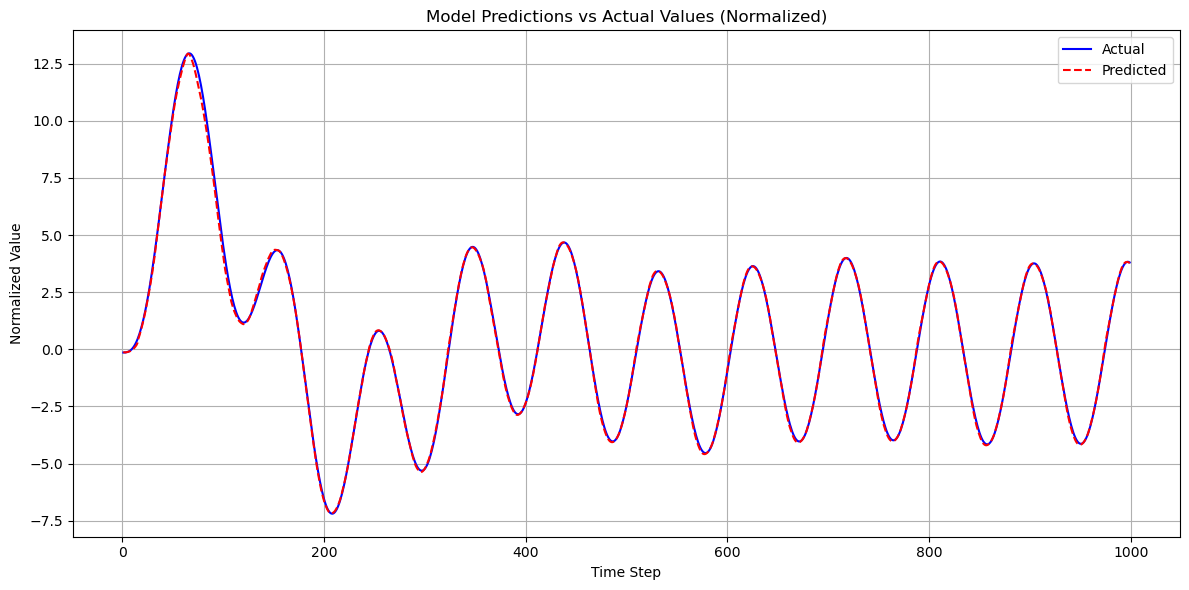

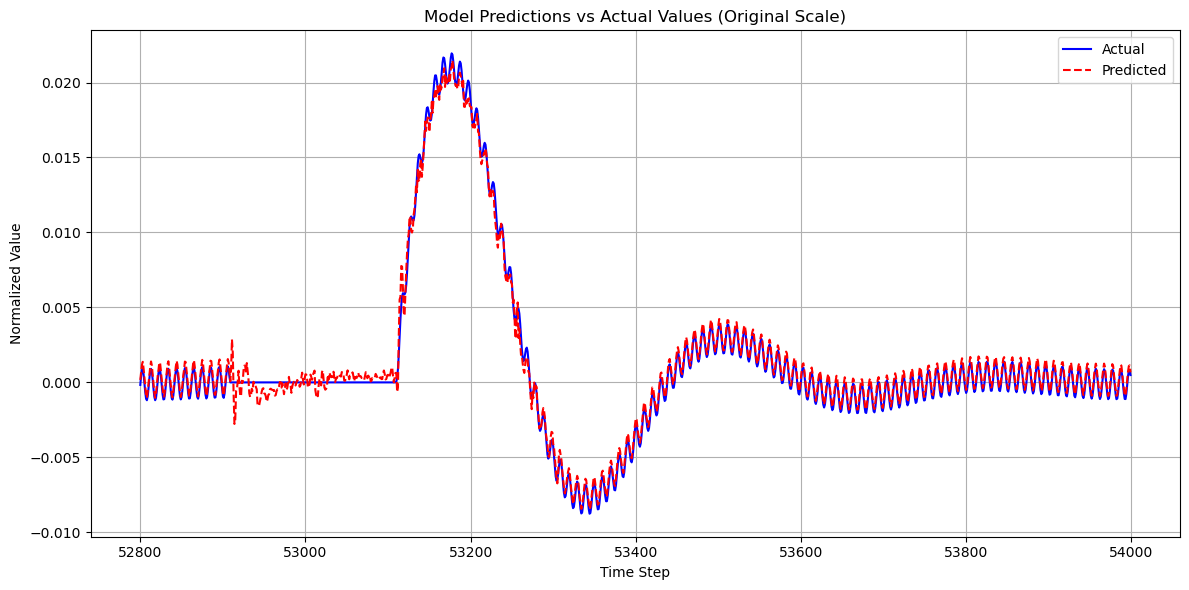

MAE: 0.0238
MSE: 0.0019
RMSE: 0.0438
MAPE: 37.1473


In [ ]:
# Plot normalized results
plot_predictions(predictions, actuals, title="Model Predictions vs Actual Values (Normalized)", samples=range(1,1000))

# Plot in original scale
predictions_original = output_scaler.inverse_transform(predictions.reshape(-1, 1))
actuals_original = output_scaler.inverse_transform(actuals.reshape(-1, 1))
plot_predictions(
    predictions_original,
    actuals_original,
    title="Model Predictions vs Actual Values (Original Scale)",
    samples=range(total_samples*(len(test_freq)-1),total_samples*(len(test_freq)-0))
)

metrics = calculate_metrics(predictions, actuals)
for metric, value in metrics.items():
	print(f'{metric}: {value:.4f}')

# Impulse Response

Generating Predictions:   4%|▎         | 36/1000 [00:00<00:02, 353.07it/s]Generating Predictions: 100%|██████████| 1000/1000 [00:02<00:00, 450.76it/s]


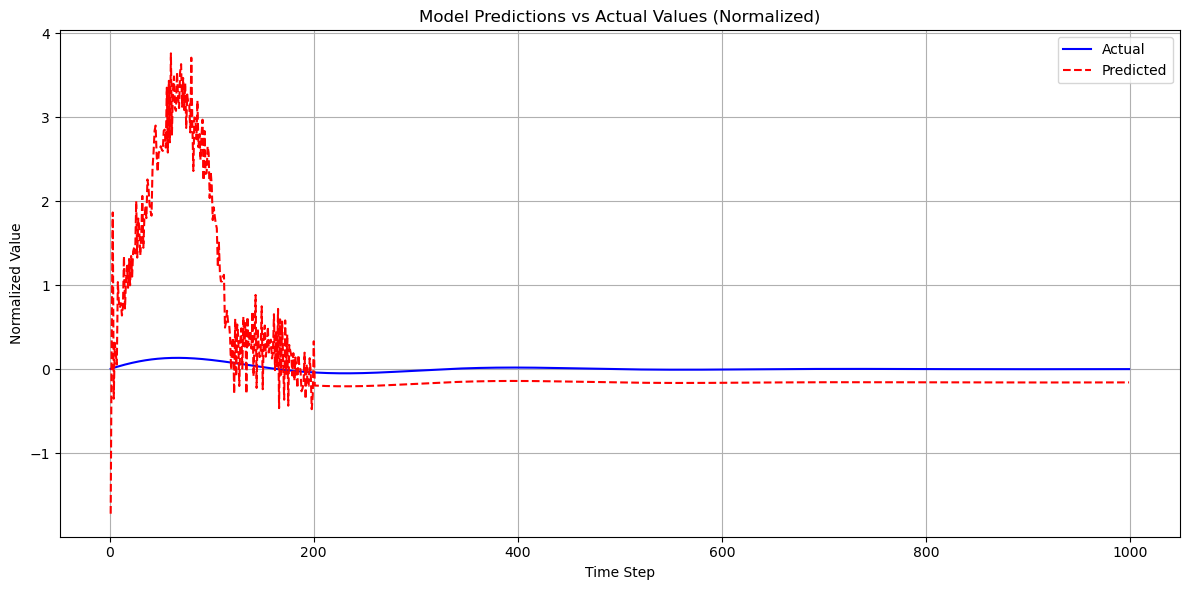

In [24]:
impulse_data = data_generator.impulse_response()
impulse_input = np.array(impulse_data['input']).reshape(-1,1)
impulse_output = np.array(impulse_data['response']).reshape(-1,1)

predictions, actuals = generate_predictions(
	model=model,
	input_data=impulse_input,
	output_data=impulse_output,
	lookback_len=lookback_len,
	feedback_len=feedback_len,
	device=device
)

plot_predictions(predictions, actuals, title="Model Predictions vs Actual Values (Normalized)", samples=range(1,len(impulse_input)-lookback_len))